<a href="https://colab.research.google.com/github/minerva-spring-pds/Group-Project-Sprint-3/blob/master/lime_cactus_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## connecting notebook to google drive
# click on the URL, give permissions and copy and paste the authorisation code to connect
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Local Interpretable Model-Agnostic Explanations (LIME) for Cactus Classification Model (Soren)

This implementation of LIME was taken largely from [Marco Tulio Correia Ribeiro's tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb?fbclid=IwAR2zmS6xUc9zbd2esk3pGc1dWxR8adF6IEXjx-q6Yq-CJ9KGPHO_0Y7XBmE).

This LIME implementation is performed on a convolutional neural network model for cactus classification using [Kaggle's cactus dataset](https://www.kaggle.com/c/aerial-cactus-identification/data).

## Importing Libraries

In [2]:
!pip install lime

from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from lime import lime_image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import os
import PIL
import cv2

%tensorflow_version 1.x

import keras
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.models import Model, load_model

TensorFlow 1.x selected.


Using TensorFlow backend.


## Importing Model

In [0]:
# make sure to place the folder in the main section of your google drive to connect to this folder
os.chdir('/gdrive/My Drive/Cactus')

In [0]:
train_label = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [0]:
## load numpy arrays below rather than the images above for faster loading

train_img = np.load('train_img.npy')
test_img = np.load('test_img.npy')
train_img_enc = np.load('train_img_enc.npy')
train_data = np.load('train_data.npy')
eval_data = np.load('eval_data.npy')

In [0]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(2, activation='softmax')(den)
    return out

In [0]:
def encoder_2(input_img_2):
  encoded_2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(input_img_2)
  encoded_2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = MaxPool2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
  print(encoded_2.shape)

  # Conv2 #
  encoded_2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = MaxPool2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
  print(encoded_2.shape)

  # Conv3 #
  encoded_2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = MaxPool2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
  print(encoded_2.shape)
  return encoded_2

In [8]:
input_img = Input(shape = (32, 32, 3))
encode = encoder_2(input_img)
full_model = Model(input_img,fc(encode))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

(?, 16, 16, 256)
(?, 8, 8, 128)
(?, 4, 4, 64)


In [0]:
full_model.load_weights('classification_model.h5')

In [11]:
full_model.weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 3, 256) dtype=float32>,
 <tf.Variable 'conv2d_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>,
 <tf.Variable 'conv2d_2/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 256, 128) dtype=float32>,
 <tf.Variable 'conv2d_3/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 128, 128) dtype=float32>,
 <tf.Variable 'conv2d_4/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'conv2d_5/kernel:0' shape=(3, 3, 128, 64) dtype=float32>,
 <tf.Variable 'conv2d_5/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 64, 64) dtype=float32>,
 <tf.Variable 'conv2d_6/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(1024, 128) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variabl

## Preprocessing data for LIME explanation

In [0]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(32, 32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

[[0.45229775 0.5477022 ]]


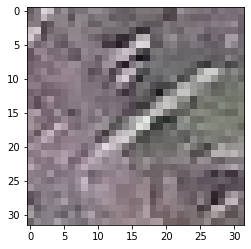

In [45]:
images = transform_img_fn(['train/fff059ecc91b30be5745e8b81111dc7b.jpg'])

plt.imshow(images[0] / 2 + 0.5)
preds = full_model.predict(images)
print(preds)

## LIME explanation

In [0]:
explainer = lime_image.LimeImageExplainer()

In [46]:
explanation = explainer.explain_instance(images[0], full_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [0]:
from skimage.segmentation import mark_boundaries

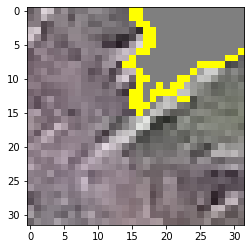

In [41]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

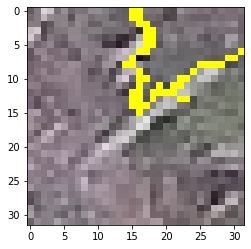

In [42]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

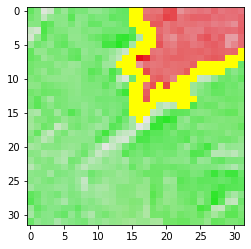

In [43]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))